# **Environment Setup**

In [44]:
# Install TensorFlow and other necessary libraries
!pip install tensorflow pandas numpy matplotlib scikit-learn
!pip install flatbuffers
!pip install tflite-support

# **Preprocessing the Data**

In [45]:
import pandas as pd
import numpy as np

# Load your dataset
data = pd.read_csv("/content/IMUdataset.csv")

# Sliding window function
def create_windows(data, window_size, stride, label_col):
    windows = []
    labels = []
    for start in range(0, len(data) - window_size + 1, stride):
        end = start + window_size
        window = data.iloc[start:end]
        windows.append(window)
        labels.append(window[label_col].iloc[-1])  # Label from the end of the window
    return windows, np.array(labels)

# Parameters
window_size = 50  # Number of samples per window
stride = 25       # Overlap between consecutive windows
label_col = 'Label'

# Create sliding windows
windows, y = create_windows(data, window_size, stride, label_col)

# Combine all sensor inputs
input_columns = ['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ', 'mX', 'mY', 'mZ']

# Check structure of windows
print(f"Type of `windows`: {type(windows)}")  # Check if it's a list of DataFrames
print(f"Type of first element in `windows`: {type(windows[0])}")

if isinstance(windows[0], pd.DataFrame):  # If each window is a DataFrame
    X = np.array([window[input_columns].values for window in windows])  # Shape: (num_samples, window_size, 9)
else:
    raise ValueError("Unsupported structure for `windows`. Expected a list of DataFrames.")

print(f"Input Shape with all sensors: {X.shape}")  # Verify the final shape is (num_samples, window_size, 9)

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train Shape: {X_train.shape}, Validation Shape: {X_val.shape}, Test Shape: {X_test.shape}")

Type of `windows`: <class 'list'>
Type of first element in `windows`: <class 'pandas.core.frame.DataFrame'>
Input Shape with all sensors: (62, 50, 9)
Train Shape: (43, 50, 9), Validation Shape: (9, 50, 9), Test Shape: (10, 50, 9)


# **Build and Train the Neural Network**

**Model Design**

In [46]:
import tensorflow as tf
from tensorflow.keras import models, layers

def create_model(input_shape):
    model = models.Sequential([
        layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(6, activation='softmax')  # 5 classes + unknown
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize model
input_shape = (window_size, 3)  # Shape of input for each sensor
model = create_model(input_shape)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)                   │ (None, 48, 32)              │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 24, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 22, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │         180,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 187,654 (733.02 KB)

 Trainable params: 187,654 (733.02 KB)

 Non-trainable params: 0 (0.00 B)

# **Model Training**


Training on accelerometer data...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.1502 - loss: 1.8017 - val_accuracy: 0.7778 - val_loss: 1.5469
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7151 - loss: 1.4772 - val_accuracy: 0.7778 - val_loss: 1.3159
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7253 - loss: 1.2341 - val_accuracy: 0.8889 - val_loss: 1.0737
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8394 - loss: 0.9731 - val_accuracy: 1.0000 - val_loss: 0.7978
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9327 - loss: 0.7538 - val_accuracy: 1.0000 - val_loss: 0.5480
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9482 - loss: 0.5436 - val_accuracy: 1.0000 - val_loss: 0.3541
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9482 - loss: 0.3780 - val_accuracy: 1.0000 - val_loss: 0.2137
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9586 - loss: 0.2523 - val_

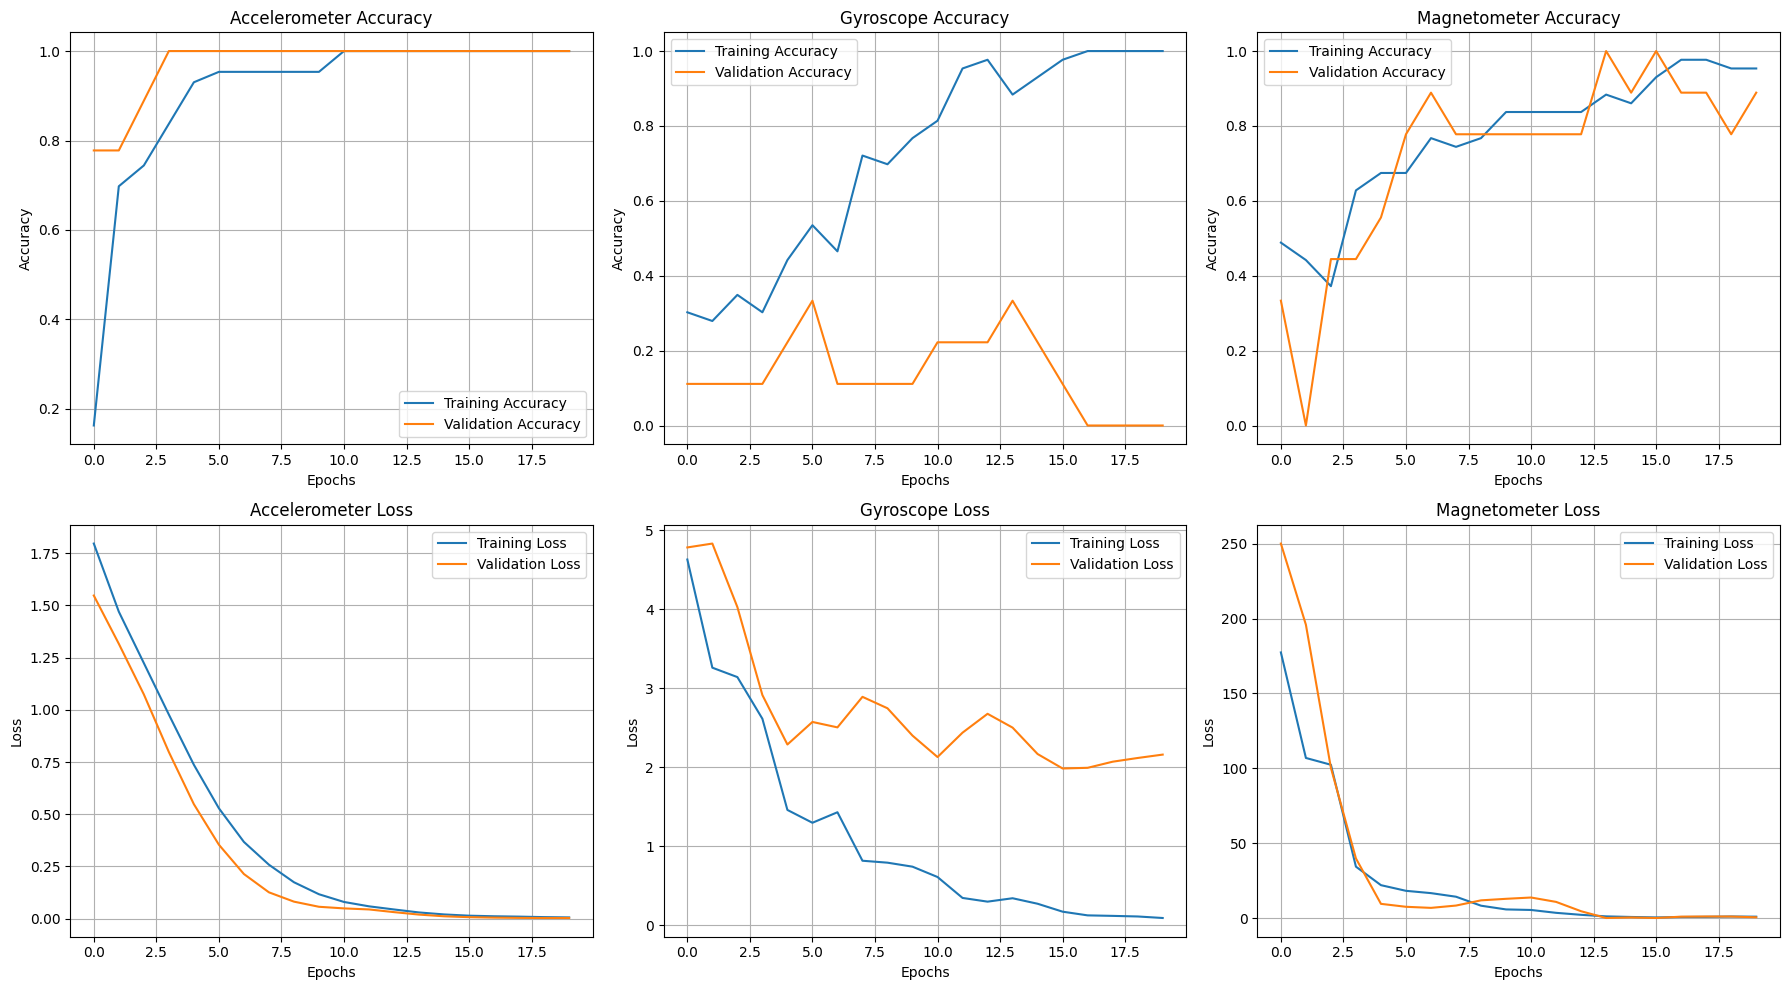

In [47]:
import matplotlib.pyplot as plt

# Dictionary to store histories for each sensor
histories = {}

for sensor, indices in {
    "accelerometer": [0, 1, 2],  # aX, aY, aZ
    "gyroscope": [3, 4, 5],      # gX, gY, gZ
    "magnetometer": [6, 7, 8]    # mX, mY, mZ
}.items():
    print(f"\nTraining on {sensor} data...")

    # Slice input data for the current sensor
    X_train_sensor = X_train[:, :, indices]  # Shape: (num_samples, window_size, 3)
    X_val_sensor = X_val[:, :, indices]      # Shape: (num_samples, window_size, 3)

    # Train the model
    history = model.fit(
        X_train_sensor, y_train,
        validation_data=(X_val_sensor, y_val),
        epochs=20,
        batch_size=32,
        verbose=1
    )

    # Store history
    histories[sensor] = history.history

# Plot training and validation accuracy and loss
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows (accuracy, loss), 3 columns (sensors)

for i, sensor in enumerate(["accelerometer", "gyroscope", "magnetometer"]):
    history = histories[sensor]

    # Plot accuracy
    axes[0, i].plot(history['accuracy'], label='Training Accuracy')
    axes[0, i].plot(history['val_accuracy'], label='Validation Accuracy')
    axes[0, i].set_title(f"{sensor.capitalize()} Accuracy")
    axes[0, i].set_xlabel("Epochs")
    axes[0, i].set_ylabel("Accuracy")
    axes[0, i].legend()
    axes[0, i].grid()

    # Plot loss
    axes[1, i].plot(history['loss'], label='Training Loss')
    axes[1, i].plot(history['val_loss'], label='Validation Loss')
    axes[1, i].set_title(f"{sensor.capitalize()} Loss")
    axes[1, i].set_xlabel("Epochs")
    axes[1, i].set_ylabel("Loss")
    axes[1, i].legend()
    axes[1, i].grid()

plt.tight_layout()
plt.show()

# **Evaluate the Model**

In [48]:
for sensor, indices in {
    "accelerometer": [0, 1, 2],  # aX, aY, aZ
    "gyroscope": [3, 4, 5],      # gX, gY, gZ
    "magnetometer": [6, 7, 8]    # mX, mY, mZ
}.items():
    print(f"\nEvaluating on {sensor} data...")

    # Slice input data for the current sensor
    X_test_sensor = X_test[:, :, indices]  # Shape: (num_samples, window_size, 3)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test_sensor, y_test, verbose=0)
    print(f"{sensor.capitalize()} Test Accuracy: {test_accuracy * 100:.2f}%")



Evaluating on accelerometer data...
Accelerometer Test Accuracy: 40.00%

Evaluating on gyroscope data...
Gyroscope Test Accuracy: 10.00%

Evaluating on magnetometer data...
Magnetometer Test Accuracy: 70.00%


# **Testing**

In [49]:
import numpy as np

# Sample accelerometer data (50 rows, 3 columns)
test_data = [
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01],
    [0.02, -0.02, 1.01]
]

# Convert to numpy array and reshape
test_input = np.array(test_data)  # Shape: (50, 3)
test_input = np.expand_dims(test_input, axis=0)  # Shape: (1, 50, 3)

# Make a prediction
predicted_probabilities = model.predict(test_input)

# Get the class with the highest probability
predicted_class = np.argmax(predicted_probabilities, axis=1)[0]

# Print the result
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Probabilities: {predicted_probabilities}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted Class: 1
Prediction Probabilities: [[0.00510343 0.5995911  0.01578248 0.02984123 0.09077899 0.2589028 ]]


# **Convert Your Model to TensorFlow Lite**

In [50]:
import tensorflow as tf
model.save('model.h5')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# Convert and save
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

# Download the file to use with Arduino
from google.colab import files
files.download('model.tflite')


Saved artifact at '/tmp/tmpb5u4d_fl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 3), dtype=tf.float32, name='keras_tensor_33')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  133199629777936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133199628028032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133199628034368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133199628031552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133199628033840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133199628033488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133199628031200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133199628034896: TensorSpec(shape=(), dtype=tf.resource, name=None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>